# .

In [ ]:
! pip install pandas
! pip install matplotlib
! pip install scipy
! pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.interpolate import Rbf
import torch

pd.set_option('display.max_columns', None)

(112, 112, 2)


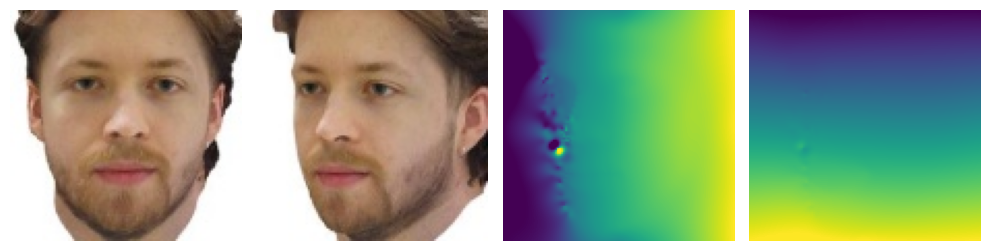

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


: 

In [ ]:
def calculate_face_correspondences_between_two_faces(source_landmarks, target_landmarks):
    w, h = 112, 112

    source_landmarks = np.array([[x * w, y * h] for x, y in source_landmarks])
    target_landmarks = np.array([[x * w, y * h] for x, y in target_landmarks])

    extra_points = np.array([
        [0, 0], [w - 1, 0], [0, h - 1], [w - 1, h - 1],  # Corners of the image
        [w // 2, 0], [w // 2, h - 1],  # Mid-top and mid-bottom
        [0, h // 2], [w - 1, h // 2]  # Mid-left and mid-right
    ])
    source_landmarks = np.vstack([source_landmarks, extra_points])
    target_landmarks = np.vstack([target_landmarks, extra_points])

    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    warped_x, warped_y = tps_transform(source_landmarks, target_landmarks, grid_x, grid_y, smooth=0.3)

    warped_x, warped_y = torch.Tensor(warped_x), torch.Tensor(warped_y)

    map_x = torch.clamp(warped_x, 0, w - 1)
    map_y = torch.clamp(warped_y, 0, h - 1)

    map_x = 2.0 * map_x / (w - 1) - 1.0
    map_y = 2.0 * map_y / (h - 1) - 1.0
    grid = torch.stack((map_x, map_y), dim=-1)  # Shape: (H, W, 2)
    return grid

def align_featuremap(featuremap, grid):
    """
    Align a single feature map using transformation grid
    """
    grid = grid.to("cuda")

    if grid.shape[:2] != featuremap.shape[1:]:
        _, target_height, target_width = featuremap.shape
        grid = grid.permute(2, 0, 1)  # [2, H, W]
        grid = F.interpolate(grid.unsqueeze(0), size=(target_height, target_width), mode='bilinear', align_corners=True)
        grid = grid.squeeze(0).permute(1, 2, 0)  # [H, W, 2]

    warped_featuremap = F.grid_sample(featuremap.unsqueeze(0), grid.unsqueeze(0), mode='bilinear', align_corners=True)

    return warped_featuremap.squeeze(0)

def tps_transform(source_points, target_points, grid_x, grid_y, smooth=0.0):
    """
    Perform Thin-Plate Spline Transformation
    """
    rbf_x = Rbf(source_points[:, 0], source_points[:, 1], target_points[:, 0], function='thin_plate', smooth=smooth)
    rbf_y = Rbf(source_points[:, 0], source_points[:, 1], target_points[:, 1], function='thin_plate', smooth=smooth)

    warped_x = rbf_x(grid_x, grid_y)
    warped_y = rbf_y(grid_x, grid_y)
    return warped_x, warped_y

if __name__ == '__main__':

    #dataset = "C:\\Users\\Eduard\\Desktop\\Face\\dataset8\\VoxCeleb1_test_dataset_TEST\\validation"
    #calculate_face_landmarks_dataset(dataset)
    #calculate_face_correspondences_dataset(dataset)
    #dataset = "C:\\Users\\Eduard\\Desktop\\Face\\dataset8\\VoxCeleb1_test_dataset_TEST\\train"
    #calculate_face_landmarks_dataset(dataset)
    #calculate_face_correspondences_dataset(dataset)

    image1_ori = cv2.imread("F:\\Face\\data\\datasets9\\test_rgb_bff_crop\\train\\bellus_50\\1e5580ed12a885bbc4b169b29f63b30bf9bb4b5a0_0_image.jpg")
    image1_ori = cv2.cvtColor(image1_ori, cv2.COLOR_BGR2RGB)
    image2_ori = cv2.imread("F:\\Face\\data\\datasets9\\test_rgb_bff_crop\\train\\bellus_50\\1e5580ed12a885bbc4b169b29f63b30bf9bb4b5a0_-25_image.jpg")
    image2_ori = cv2.cvtColor(image2_ori, cv2.COLOR_BGR2RGB)
    
    landmarks1 = np.load("F:\\Face\\data\\datasets9\\test_rgb_bff_crop_lc\\train\\bellus_50\\1e5580ed12a885bbc4b169b29f63b30bf9bb4b5a0_0_image.npz")["landmarks"]
    landmarks2 = np.load("F:\\Face\\data\\datasets9\\test_rgb_bff_crop_lc\\train\\bellus_50\\1e5580ed12a885bbc4b169b29f63b30bf9bb4b5a0_-25_image.npz")["landmarks"]
    
    grid = calculate_face_correspondences_between_two_faces(landmarks2, landmarks1).numpy()

    print(grid.shape)

    fig, axes = plt.subplots(1, 4, figsize=(10, 5))
    axes[0].imshow(image1_ori)
    axes[0].axis('off')
    axes[1].imshow(image2_ori)
    axes[1].axis('off')
    axes[2].imshow(grid[:,:,0])
    axes[2].axis('off')
    axes[3].imshow(grid[:,:,1])
    axes[3].axis('off')
    plt.tight_layout()
    plt.show()

    exit()
    # h1, w1, _ = image1_ori.shape
    # h2, w2, _ = image2_ori.shape
    #
    # points1 = np.array([[x * w1, y * h1] for x,y in ori_landmarks1])
    # points2 = np.array([[x * w2, y * h2] for x,y in ori_landmarks2])
    #
    # extra_points = np.array([
    #     [0, 0], [w1 - 1, 0], [0, h1 - 1], [w1 - 1, h1 - 1],  # Corners of the image
    #     [w1 // 2, 0], [w1 // 2, h1 - 1],  # Mid-top and mid-bottom
    #     [0, h1 // 2], [w1 - 1, h1 // 2]  # Mid-left and mid-right
    # ])
    # points1 = np.vstack([points1, extra_points])
    # points2 = np.vstack([points2, extra_points])
    #
    # grid_x, grid_y = np.meshgrid(np.arange(w2), np.arange(h2))
    # warped_x, warped_y = tps_transform(points1, points2, grid_x, grid_y, smooth=0.3)
    #
    # warped_x, warped_y = torch.Tensor(warped_x), torch.Tensor(warped_y)
    #
    # map_x = torch.clamp(warped_x, 0, w1 - 1)
    # map_y = torch.clamp(warped_y, 0, h1 - 1)
    #
    # map_x = 2.0 * map_x / (w1 - 1) - 1.0
    # map_y = 2.0 * map_y / (h1 - 1) - 1.0
    # grid = torch.stack((map_x, map_y), dim=-1)  # Shape: (H, W, 2)

    # # Add batch dimension and permute to (B, H, W, 2)
    # grid = grid.unsqueeze(0)
    #
    # # Perform grid sampling
    # image2 = transforms.ToTensor()(image2_ori)
    # image2 = transforms.Resize((112,112))(image2)
    # image2 = image2.unsqueeze(0)  # Add batch dimension
    # warped_image = F.grid_sample(image2, grid, mode='bilinear', align_corners=True).squeeze(0)
    # warped_image = np.transpose(warped_image.numpy(), (1, 2, 0))
    #
    #
    # #map_x = np.clip(warped_x, 0, w1 - 1).astype(np.float32)
    # #map_y = np.clip(warped_y, 0, h1 - 1).astype(np.float32)
    # #warped_image2 = cv2.remap(image2_ori, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    #
    # fig, axes = plt.subplots(1, 4, figsize=(10, 5))
    # axes[0].imshow(image1_ori)
    # axes[0].axis('off')
    # axes[1].imshow(warped_image)
    # axes[1].axis('off')
    # #axes[2].imshow(warped_image2)
    # axes[2].axis('off')
    # axes[3].imshow(image2_ori)
    # axes[3].axis('off')
    # plt.tight_layout()
    # plt.show()
    # raise Exception()

    from torchvision.transforms import transforms
    import torch.nn.functional as F

    image1_ori = cv2.imread("C:\\Users\\Eduard\\Desktop\\Face\\dataset8\\VoxCeleb1_test_dataset_TEST\\validation\\id10270\\f03463d2c721f7f05304c9826ef170c99b8a78850_0_image.jpg")
    image1_ori = cv2.cvtColor(image1_ori, cv2.COLOR_BGR2RGB)
    image2_ori = cv2.imread("C:\\Users\\Eduard\\Desktop\\Face\\dataset8\\VoxCeleb1_test_dataset_TEST\\validation\\id10270\\f03463d2c721f7f05304c9826ef170c99b8a788525_-25_image.jpg")
    image2_ori = cv2.cvtColor(image2_ori, cv2.COLOR_BGR2RGB)
    image2 = transforms.ToTensor()(image2_ori)
    image2 = transforms.Resize((112,112))(image2)

    ori_grid = np.load("C:\\Users\\Eduard\\Desktop\\Face\\dataset8\\VoxCeleb1_test_dataset_TEST\\validation\\id10270\\f03463d2c721f7f05304c9826ef170c99b8a788525_-25_corr.npz")["corr"]
    grid = torch.Tensor(ori_grid)
    print(grid.shape[:2], image2.shape[1:])
    if grid.shape[:2] != image2.shape[1:]:
        print("RESIZE")
        _, target_height, target_width = image2.shape
        # Reshape grid for interpolation
        grid = grid.permute(2, 0, 1)  # [1, 2, H, W]
        # Resize using bilinear interpolation
        grid = F.interpolate(grid, size=(target_height, target_width), mode='bilinear', align_corners=True)
        # Reshape back to grid format [1, target_height, target_width, 2]
        grid = grid.permute(1, 2, 0)

    grid = grid.unsqueeze(0)

    image2 = transforms.ToTensor()(image2_ori)
    image2 = transforms.Resize((112,112))(image2)
    image2 = image2.unsqueeze(0)  # Add batch dimension
    warped_image = F.grid_sample(image2, grid, mode='bilinear', align_corners=True).squeeze(0)
    warped_image = np.transpose(warped_image.numpy(), (1, 2, 0))

    fig, axes = plt.subplots(1, 5, figsize=(10, 5))
    axes[0].imshow(ori_grid[:, :, 0], cmap='viridis')
    axes[0].set_title("Slice 1")
    axes[0].axis('off')
    axes[1].imshow(ori_grid[:, :, 1], cmap='viridis')
    axes[1].set_title("Slice 2")
    axes[1].axis('off')
    axes[2].imshow(warped_image)
    axes[2].set_title("Slice 2")
    axes[2].axis('off')
    axes[3].imshow(image2_ori)
    axes[3].axis('off')
    axes[4].imshow(image1_ori)
    axes[4].axis('off')
    plt.tight_layout()
    plt.show()